# Fitting the model

## Data Preprocessing

First we need to import the libraries and the data.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/data_clean.csv', index_col = 0)
df.head()

,backers_count,country,id,name,staff_pick,state,usd_pledged,usd_type,yr_launched,mo_launched,...,main_category,subcategory,city,region,city_type,creator_id,creator_num_projects,words_blurb,polarity_blurb,subjectivity_blurb
0,21,US,287514992,New Final Round Album,0,1,802.00000,international,2013,12,...,Music,Rock,Chicago,IL,Town,1495925645,1,26,0.178788,0.518182
1,97,US,385129759,Princess Pals Enamel Pin Series,0,1,2259.00000,international,2019,2,...,Art,Mixed Media,Sacramento,CA,Town,1175589980,4,9,0.625000,1.000000
2,88,US,681033598,Their Life Through Their Lens-the Amish and Me...,1,1,29638.00000,international,2016,11,...,Photography,Photobooks,Columbus,OH,Town,1196856269,2,25,0.225000,0.366667
3,193,IT,1031782682,WAO: THE ECO EFFECT SHOES,0,1,49075.15252,international,2018,10,...,Fashion,Footwear,Venice,Veneto,Town,1569700626,2,13,0.000000,0.100000
4,20,US,904085819,Apple Watch Development Course,0,0,549.00000,domestic,2015,3,...,Technology,Software,Redmond,WA,Town,1870845385,1,22,0.156250,0.400000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   backers_count         184113 non-null  int64  
 1   country               184113 non-null  object 
 2   id                    184113 non-null  int64  
 3   name                  184113 non-null  object 
 4   staff_pick            184113 non-null  int64  
 5   state                 184113 non-null  int64  
 6   usd_pledged           184113 non-null  float64
 7   usd_type              184113 non-null  object 
 8   yr_launched           184113 non-null  int64  
 9   mo_launched           184113 non-null  int64  
 10  wd_launched           184113 non-null  int64  
 11  yr_deadline           184113 non-null  int64  
 12  mo_deadline           184113 non-null  int64  
 13  wd_deadline           184113 non-null  int64  
 14  founding_phase        184113 non-null  int64  
 15  

Let us delete all the variables that are not going to be useful in our model:
+ **"id", "creator_id", "name"**: are not interesting to make a prediction
+ **"disable_communication", "is starrable"**: only False
+ **"city", "region"**: these two variables will create too many columns in the One Hot encoding process. We keep "country"
+ **"yr_deadline","mo_deadline", "wd_deadline"**: these variables are hihgly correlated with the launching date and "funding_phase"

In [4]:
df.drop(['id', 'name', 'yr_deadline',"mo_deadline", "wd_deadline", "city", "region","subcategory","creator_id"], axis=1, inplace=True)  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   backers_count         184113 non-null  int64  
 1   country               184113 non-null  object 
 2   staff_pick            184113 non-null  int64  
 3   state                 184113 non-null  int64  
 4   usd_pledged           184113 non-null  float64
 5   usd_type              184113 non-null  object 
 6   yr_launched           184113 non-null  int64  
 7   mo_launched           184113 non-null  int64  
 8   wd_launched           184113 non-null  int64  
 9   founding_phase        184113 non-null  int64  
 10  phase_before          184113 non-null  int64  
 11  goal_usd              184113 non-null  float64
 12  main_category         184113 non-null  object 
 13  city_type             184113 non-null  object 
 14  creator_num_projects  184113 non-null  int64  
 15  

We split the variables in Categorical and Numerical variables.

In [5]:
cat_features = list(df.columns[df.dtypes==object])

num_features = list(df.columns[df.dtypes!=object])

num_features.remove('usd_pledged')
num_features.remove("backers_count")
num_features.remove("state")

 We also split the target of the data and then into Train and Test.

In [6]:
# Define predictors and target variable

X = df.drop(['usd_pledged', "backers_count", "state"], axis=1)
y = df['state']

print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 184113 observations in our dataset and 15 features
Our target vector has also 184113 values


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## First model

We need to set a reference in order to compare how good our model is. We will use the *Logistic Regression* for this purpose. But first we need to convert the categorical variables into numerical with a *OneHotEconde* and we will also scale the data. 

In [8]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [10]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [11]:
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [12]:
def print_scores(y_true, y_predicted):
# This function prints out the scores and the confussion matrix

    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_true, y_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_true, y_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_true, y_predicted)))

    cm = confusion_matrix(y_true, y_predicted)
    print("")
    print("Confusion matrix:")
    print('-------------------------')
    print(cm)

In [13]:
print_scores(y_train, y_train_predicted)

Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.87
Precision: 0.74

Confusion matrix:
-------------------------
[[29617 27448]
 [11772 78453]]


In [14]:
pipe_logreg.fit(X_train, y_train)
y_pred = pipe_logreg.predict(X_test)

In [15]:
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.87
Precision: 0.74

Confusion matrix:
-------------------------
[[ 7463  6842]
 [ 3036 19482]]


## Model Benchmark

With a reference we can now try different models and see how the score, we will use the accuracy as metric.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [18]:
models = [DecisionTreeClassifier(max_depth=6, random_state=RSEED ),
        RandomForestClassifier(n_estimators=200,max_depth=6 , random_state=RSEED, n_jobs = -1), 
        AdaBoostClassifier(random_state=RSEED),        
        xgb.XGBClassifier(random_state=RSEED, n_jobs = -1, eval_metric = "error"),
        RidgeClassifier(),
        LogisticRegression(max_iter=1000)]

model_name = ["DecisionTree", "RandomForest","AdaBoost","XGBoost", "RidgeRegression", "LogisticRegression"]
accuracy = []
recall = []
precision = []
accuracy_test = []
recall_test = []
precision_test = []

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

k = len(models)

for i in range(k):
    model = models[i].fit(X_train_prep, y_train)  
    y_pred = models[i].predict(X_train_prep)
    y_pred_test = models[i].predict(X_test_prep)
    
    accuracy.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))
    
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    precision_test.append(precision_score(y_test, y_pred_test))
    
    print(f"Model {model_name[i]} done!")

df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precission_train": precision,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precission_test": precision_test,
                         })


Model DecisionTree done!
Model RandomForest done!
Model AdaBoost done!
Model XGBoost done!
Model RidgeRegression done!
Model LogisticRegression done!


In [19]:
df_scores.sort_values("accuracy_test", ascending = False).head(20)

,name,accuracy_train,recall_train,precission_train,accuracy_test,recall_test,precission_test
3,XGBoost,0.815968,0.866888,0.838218,0.795318,0.847100,0.823298
2,AdaBoost,0.773494,0.828861,0.806688,0.773620,0.824318,0.809084
0,DecisionTree,0.771885,0.840953,0.797643,0.770388,0.836975,0.797554
1,RandomForest,0.760710,0.914514,0.749809,0.760829,0.911804,0.750631
5,LogisticRegression,0.734096,0.869859,0.741063,0.731744,0.865175,0.740085
4,RidgeRegression,0.696965,0.911654,0.691693,0.697961,0.908562,0.693009


Text(0.5, 1.0, 'Model Accuracy ')

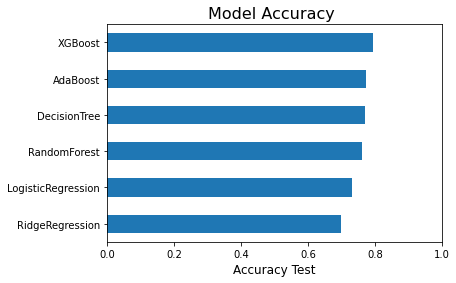

In [20]:
ax = plt.Figure()

plot1 = df_scores.sort_values("accuracy_test", ascending = True).plot(kind= "barh", x= "name", y = "accuracy_test", legend=None)
plt.xlim([0,1])
plot1.set_xlabel('Accuracy Test', fontsize = 12)
plot1.set_ylabel('', fontsize = 12)
plot1.set_title('Model Accuracy ', fontsize = 16)

Good! Now we will take the best candidates and optimaze them.

## XGBoost

We start with the best one: XGBoost. To find the best paramters we use a RandomizedSearch and then a GridSearch around the best parameters combination from the previous step

In [21]:
##Cell used for the optimization
'''
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': list(range(3,15)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree"]}

# Instantiate random search and define the metric to optimize 
rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state = RSEED,n_jobs = -1), param_grid_xgb, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state = RSEED)

# Fit randomized search object to data
rs_xgb.fit(X_train_prep, y_train)

rs_xgb.best_params_
'''

'\nparam_grid_xgb = {\n    \'n_estimators\': [100],\n    \'max_depth\': list(range(3,15)),\n    "learning_rate": np.linspace(0.0001, 1).astype(float),\n    \'booster\': ["gbtree"]}\n\n# Instantiate random search and define the metric to optimize \nrs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state = RSEED,n_jobs = -1), param_grid_xgb, scoring=\'accuracy\',\n                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state = RSEED)\n\n# Fit randomized search object to data\nrs_xgb.fit(X_train_prep, y_train)\n\nrs_xgb.best_params_\n'

In [22]:
# parameters around  the best model of the Random Search {'n_estimators': 25,'max_depth': 7,'learning_rate': 0.34700408163265306, 'booster': 'gbtree'}

'''
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth' : [9],
    "learning_rate": list(np.linspace(0.1,0.2,3)),
    'booster': ["gbtree"]}

grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state = RSEED, n_jobs = -1), param_grid=param_grid_xgb, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_xgb.fit(X_train_prep, y_train)

best_xgb = grid_xgb.best_estimator_
'''

'\nparam_grid_xgb = {\n    \'n_estimators\': [100],\n    \'max_depth\' : [9],\n    "learning_rate": list(np.linspace(0.1,0.2,3)),\n    \'booster\': ["gbtree"]}\n\ngrid_xgb = GridSearchCV(xgb.XGBClassifier(random_state = RSEED, n_jobs = -1), param_grid=param_grid_xgb, cv=5, scoring=\'accuracy\', \n                           verbose=5, n_jobs=-1)\ngrid_xgb.fit(X_train_prep, y_train)\n\nbest_xgb = grid_xgb.best_estimator_\n'

In [26]:
best_xgb = xgb.XGBClassifier(random_state = RSEED, n_jobs = -1,
                             n_estimators = 100, booster = "gbtree",
                             learning_rate = 0.1, max_depth = 9,
                            eval_metric = "error")

best_xgb.fit(X_train_prep, y_train)
y_train_pred = best_xgb.predict(X_train_prep)
y_pred = best_xgb.predict(X_test_prep)

#grid_xgb.best_params_

In [27]:
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.82
Recall: 0.87
Precision: 0.84

Confusion matrix:
-------------------------
[[42540 14525]
 [11402 78823]]
Cross validation scores:
-------------------------
Accuracy: 0.80
Recall: 0.85
Precision: 0.82

Confusion matrix:
-------------------------
[[10174  4131]
 [ 3406 19112]]


Well, we got an extra % of accuracy. Let us check out which are the most important parameters in our model.

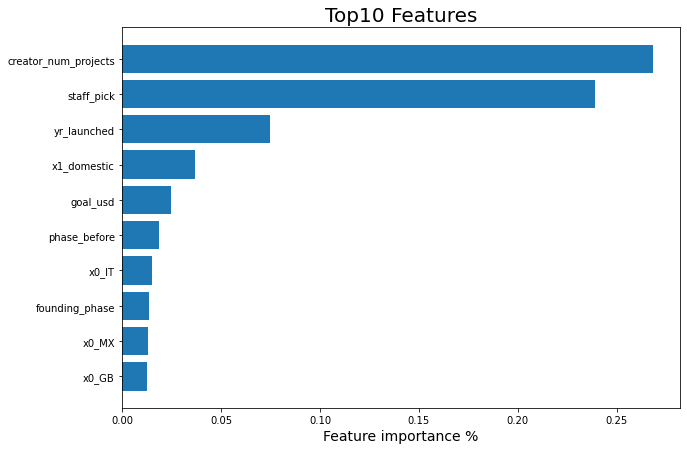

In [28]:
hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names()
column_names = num_features + list(hot_encoder_names)

importance = list(best_xgb.feature_importances_)


fig, ax = plt.subplots(figsize = (10,7))

df_importance = pd.DataFrame({"Feature": column_names, "Importance": importance})
df_importance.sort_values("Importance", ascending = True, inplace = True)

ax.barh(df_importance["Feature"].tail(10), df_importance["Importance"].tail(10))

ax.set_xlabel('Feature importance %', fontsize = 14)
ax.set_ylabel('', fontsize = 12)
ax.set_title('Top10 Features', fontsize = 20)

plt.savefig('Features_importance.png', transparent=True)

In [29]:
model_name.append("XGBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

## AdaBoost

We use the same strategy to optimize the AdaBoost model.

In [30]:
''''

param_grid_ada = {
    'n_estimators': np.linspace(100, 500, 20).astype(int)}

# Instantiate random search and define the metric to optimize 
rs_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid_ada, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)

# Fit randomized search object to data
rs_ada.fit(X_train_prep, y_train)

best_ada = rs_ada.best_estimator_

y_train_pred = best_ada.predict(X_train_prep)
y_pred = best_ada.predict(X_test_prep)
rs_ada.best_params_
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)
'''

"'\n\nparam_grid_ada = {\n    'n_estimators': np.linspace(100, 500, 20).astype(int)}\n\n# Instantiate random search and define the metric to optimize \nrs_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid_ada, scoring='accuracy',\n                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)\n\n# Fit randomized search object to data\nrs_ada.fit(X_train_prep, y_train)\n\nbest_ada = rs_ada.best_estimator_\n\ny_train_pred = best_ada.predict(X_train_prep)\ny_pred = best_ada.predict(X_test_prep)\nrs_ada.best_params_\nprint_scores(y_train, y_train_pred)\nprint_scores(y_test, y_pred)\n"

In [31]:

'''
param_grid_ada = {
    'n_estimators': np.linspace(150, 250, 3).astype(int),
    "learning_rate": np.linspace(0.5, 1, 3).astype(float)}

grid_ada = GridSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid=param_grid_ada, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

grid_ada.fit(X_train_prep, y_train)

best_grid_ada = grid_ada.best_estimator_

y_train_pred = best_grid_ada.predict(X_train_prep)
y_pred = best_grid_ada.predict(X_test_prep)

grid_ada.best_params_
'''

'\nparam_grid_ada = {\n    \'n_estimators\': np.linspace(150, 250, 3).astype(int),\n    "learning_rate": np.linspace(0.5, 1, 3).astype(float)}\n\ngrid_ada = GridSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid=param_grid_ada, cv=5, scoring=\'accuracy\', \n                           verbose=5, n_jobs=-1)\n\ngrid_ada.fit(X_train_prep, y_train)\n\nbest_grid_ada = grid_ada.best_estimator_\n\ny_train_pred = best_grid_ada.predict(X_train_prep)\ny_pred = best_grid_ada.predict(X_test_prep)\n\ngrid_ada.best_params_\n'

In [32]:
ada2 = AdaBoostClassifier(n_estimators=225, learning_rate=1.0, random_state=RSEED)
ada2.fit(X_train_prep, y_train)

y_train_pred = ada2.predict(X_train_prep)
y_pred = ada2.predict(X_test_prep)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.83
Precision: 0.81

Confusion matrix:
-------------------------
[[39300 17765]
 [15226 74999]]
Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.83
Precision: 0.81

Confusion matrix:
-------------------------
[[ 9944  4361]
 [ 3902 18616]]


In [33]:
model_name.append("AdaBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# Cell used for the optimization
# {'rf__n_estimators': 200,'rf__max_features': 8,'rf__max_depth': 10,'dt__max_depth': 10}

'''
clf1 = DecisionTreeClassifier(random_state=RSEED)
clf2 = RandomForestClassifier(random_state=RSEED)
clf3 = LogisticRegression(random_state=RSEED)

params = {'dt__max_depth': [5, 10], 'rf__n_estimators': [20, 200],'rf__max_depth': [5, 10], 'rf__max_features': [6, 8], }

eclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

random_search = RandomizedSearchCV(eclf, param_distributions=params,n_iter=4)
random_search.fit(X_train_prep, y_train)

best_rs = random_search.best_estimator_
random_search.best_params_

'''

In [ ]:
clf1 = DecisionTreeClassifier(random_state=RSEED, max_depth = 10)
clf2 = RandomForestClassifier(random_state=RSEED, max_depth = 10, max_features = 8, n_estimators = 200)
clf3 = LogisticRegression(random_state=RSEED)

eclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

In [ ]:
y_train_pred = best_rs.predict(X_train_prep)
y_pred = best_rs.predict(X_test_prep)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

In [ ]:
model_name.append("Voting Classifier")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

In [ ]:
df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precission_train": precision,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precission_test": precision_test,
                         })

In [ ]:
df_scores.sort_values("accuracy_test", ascending = True , inplace= True)

fig, ax = plt.subplots(figsize = (10,7))

color_list = ["lightblue"] * len(df_scores["name"].to_list())

color_list[-1] = "lightgreen"
color_list[-3] = "lightgreen"
color_list[-4] = "lightgreen"

#plot1 = df_scores.sort_values("accuracy_test", ascending = True).plot

hbars = ax.barh(df_scores["name"], df_scores["accuracy_test"], align='center', color =color_list)

plt.xlim([0,1])

ax.set_xlabel('Accuracy Test', fontsize = 12)
ax.set_ylabel('.')
ax.set_title('Model Accuracy ', fontsize = 24)

plt.savefig('Models_accuracy.png', transparent=False)